# Exploratory Data Analysis (EDA)
## WiDS Global Datathon – Wildfire Prediction

This notebook explores the structure of the wildfire dataset used to predict
whether and when a wildfire will threaten an evacuation zone. All analysis
focuses on information available within the first five hours after ignition.

In [2]:
import sys
sys.executable


'c:\\Users\\danni\\AppData\\Local\\Programs\\Python\\Python310\\python.exe'

## Data Loading

We begin by loading the training data, test data, and metadata file provided
by the competition.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
metadata = pd.read_csv("metaData.csv")

train.shape, test.shape


((221, 37), (95, 35))

## Feature Overview

This section inspects the available features in the training dataset,
including fire growth metrics, spatial movement indicators, and temporal
context variables.


In [4]:
train.columns




Index(['event_id', 'num_perimeters_0_5h', 'dt_first_last_0_5h',
       'low_temporal_resolution_0_5h', 'area_first_ha', 'area_growth_abs_0_5h',
       'area_growth_rel_0_5h', 'area_growth_rate_ha_per_h', 'log1p_area_first',
       'log1p_growth', 'log_area_ratio_0_5h', 'relative_growth_0_5h',
       'radial_growth_m', 'radial_growth_rate_m_per_h',
       'centroid_displacement_m', 'centroid_speed_m_per_h',
       'spread_bearing_deg', 'spread_bearing_sin', 'spread_bearing_cos',
       'dist_min_ci_0_5h', 'dist_std_ci_0_5h', 'dist_change_ci_0_5h',
       'dist_slope_ci_0_5h', 'closing_speed_m_per_h',
       'closing_speed_abs_m_per_h', 'projected_advance_m',
       'dist_accel_m_per_h2', 'dist_fit_r2_0_5h', 'alignment_cos',
       'alignment_abs', 'cross_track_component', 'along_track_speed',
       'event_start_hour', 'event_start_dayofweek', 'event_start_month',
       'time_to_hit_hours', 'event'],
      dtype='object')

## Target Variable Investigation

The dataset does not include separate binary labels for each prediction horizon.
Instead, targets are defined using a time-to-event formulation.


In [5]:
[col for col in train.columns if "12" in col or "24" in col or "48" in col or "72" in col]

[]

## Time-to-Event Labels

The variable `event` indicates whether a wildfire ever threatens an evacuation zone.
The variable `time_to_hit_hours` represents the number of hours after ignition at
which that threat occurs. If a fire reaches an evacuation zone within 72 hours, event is 1 and time_to_hit_hours is observed. If a fire does not reach an evacuation zone within 72 hours, event is 0 and time_to_hit_hours is censored at the last available observation. These variables are used to derive binary targets for
multiple prediction horizons.


## Kaplan Meier Curves
We have to use both `event` + `time_to_hit_hours` to predict probability of a fire hitting by a certain time. Since there's two factors to take into consideration for the final predictions, we can't just use a standard correlation coefficient (kaplan, pearson, kendall, etc.) to see how the columns are related. If we only see how different columns are related to `event`, then this ignores the `time_to_hit_hours` column and just gives us info on columns correlated to IF a fire occurs and not WHEN. We also can't just see how columns are related to `time_to_hit_hours` because that doesn't give us info on if a fire occurred or not (because the censoring stops `time_to_hit_hours` at the last available observation). The censored data (when the fire hasn't hit by 72 hours) also means we don't know if a fire hits or not, we just know it hasn't hit by 72 hours. 

Kaplan Meier shows event changing over time but standard correlation is more linear relationships that don't really take time into account. Kaplan Meier is a stepwise function basically that drops every single time an event (fire hitting) occurs. The lower the curve, the more likely a fire hits. It's designed to take in a binary event (occurring or not) as well as time which are the two targets we're given. So we can use Kaplan Meier to plot what's going on with our fire data.

In [6]:
#kaplan meier curve for time to fire
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

kmf.fit(
    durations=train["time_to_hit_hours"],
    event_observed=train["event"],
    label="All Fires"
)

plt.figure()
kmf.plot_survival_function()
plt.title("Kaplan-Meier Curve for Time to Fire")   
plt.xlabel("Time to Fire (hours)")
plt.ylabel("Survival Probability") #aka probability of not having a fire yet
# higher probability means more likely fire hasn't hit, lower probability means more likely fire has hit
plt.show()

ModuleNotFoundError: No module named 'lifelines'

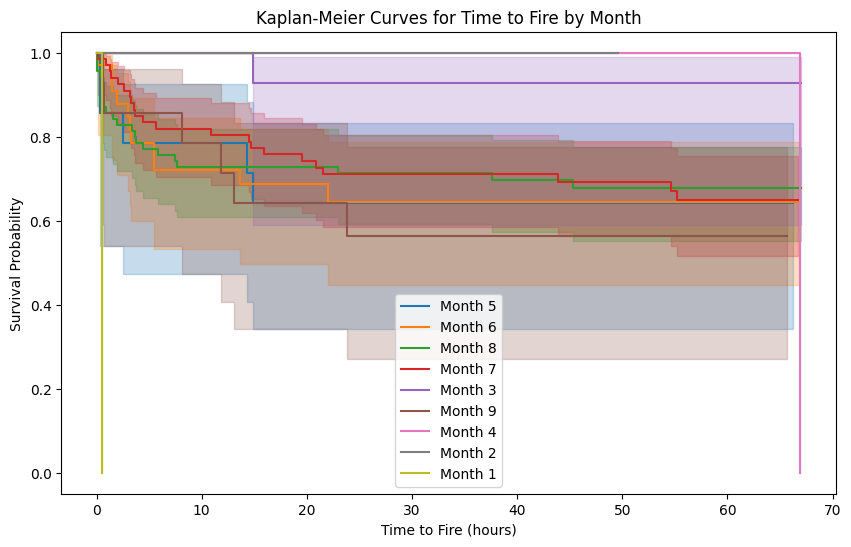

In [ ]:
# stratified kaplan meier curve for time to fire by temporal features
# 1. by month (using event_start_month)
kmf = KaplanMeierFitter()
months = train["event_start_month"].unique()
plt.figure(figsize=(10, 6))
for month in months:
    subset = train[train["event_start_month"] == month] #select rows where event_start_month is equal to the current month
    kmf.fit(
        durations=subset["time_to_hit_hours"],
        event_observed=subset["event"],
        label=f"Month {month}"
    )
    kmf.plot_survival_function()
plt.title("Kaplan-Meier Curves for Time to Fire by Month")
plt.xlabel("Time to Fire (hours)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

steep drop: rapid rate of event occurring

shaded bands are confidence intervals - wider = higher uncertainty

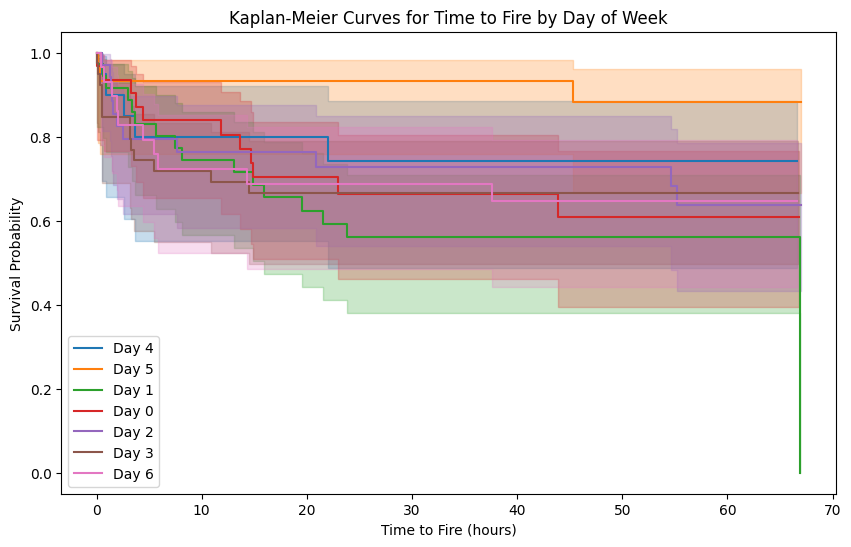

In [ ]:
# 2. by day of week (using event_start_dayofweek)
kmf = KaplanMeierFitter()
days = train["event_start_dayofweek"].unique()
plt.figure(figsize=(10, 6))
for day in days:
    subset = train[train["event_start_dayofweek"] == day]
    kmf.fit(
        durations=subset["time_to_hit_hours"],
        event_observed=subset["event"],
        label=f"Day {day}"
    )
    kmf.plot_survival_function()
plt.title("Kaplan-Meier Curves for Time to Fire by Day of Week")
plt.xlabel("Time to Fire (hours)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

a lot of the curves overlap so there's not a strong separation between a fire hitting and what day of the week it started - makes sense

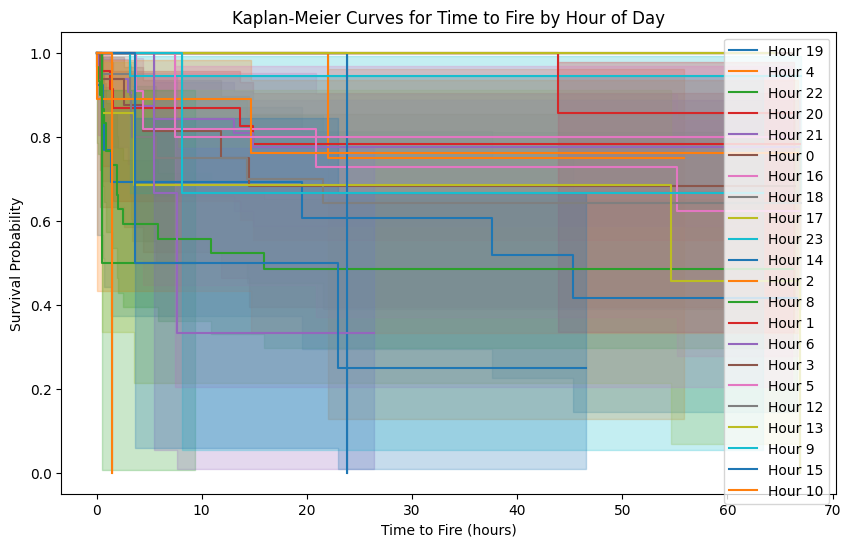

In [ ]:
# 3. by hour of day (using event_start_hour)
kmf = KaplanMeierFitter()
hours = train["event_start_hour"].unique()
plt.figure(figsize=(10, 6))
for hour in hours:
    subset = train[train["event_start_hour"] == hour]
    kmf.fit(
        durations=subset["time_to_hit_hours"],
        event_observed=subset["event"],
        label=f"Hour {hour}"
    )
    kmf.plot_survival_function()
plt.title("Kaplan-Meier Curves for Time to Fire by Hour of Day")
plt.xlabel("Time to Fire (hours)")
plt.ylabel("Survival Probability")
plt.legend(loc ="upper right")
plt.show()

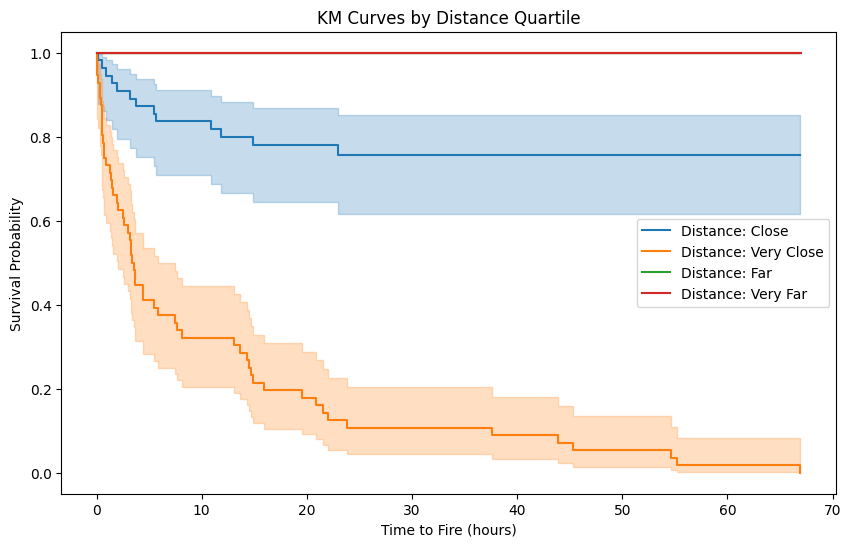

In [ ]:
# stratified by minimum distance to nearest evac zone centroid (meters) (using dist_min_ci_0_5h)
kmf = KaplanMeierFitter()

# Don't want to have each unique distance in its own curve because the graph is unreadable, creating 4 distance groups instead
distance_groups = pd.qcut(
    train["dist_min_ci_0_5h"],
    q=4,
    labels=["Very Close", "Close", "Far", "Very Far"]
)

plt.figure(figsize=(10, 6))

for group in distance_groups.unique():
    subset = train[distance_groups == group]
    kmf.fit(
        durations=subset["time_to_hit_hours"],
        event_observed=subset["event"],
        label=f"Distance: {group}"
    )
    kmf.plot_survival_function()

plt.title("KM Curves by Distance Quartile")
plt.xlabel("Time to Fire (hours)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

graph behaves as we expect where close and very close fires to evacuation zones have lower survival probability (aka fire hits)

## Missing Data Analysis (EDA)

In [9]:
missing = train.isna().mean().sort_values(ascending=False)
missing = (missing * 100).round(2)
missing[missing > 0]



Series([], dtype: float64)

In [10]:
if missing.sum() == 0:
    print("✓ No missing values found in any columns.")
else:
    missing_nonzero = missing[missing > 0].head(15)
    plt.figure(figsize=(10, 5))
    missing_nonzero.sort_values().plot(kind="barh")
    plt.title("Top Missingness (% of rows)")
    plt.xlabel("Missing (%)")
    plt.tight_layout()
    plt.show()


✓ No missing values found in any columns.


### Missing Data Findings

No missing values were detected in the training dataset.  
This suggests the dataset has been pre-cleaned and does not require imputation.

Implication for modeling:
- No need for missing value handling strategies.
- All features are fully populated and usable for model training.


## Duplicate Data Analysis 

In [11]:
duplicates = train.duplicated().sum()
print(f"Total duplicate rows: {duplicates}")

if 'event_id' in train.columns:
    duplicate_ids = train['event_id'].duplicated().sum()
    print(f"Duplicate event_id values: {duplicate_ids}")


Total duplicate rows: 0
Duplicate event_id values: 0


### Duplicate Data Findings

- Duplicate rows: 0
- Duplicate event_id values: 0

Implication:
Zero duplicates exist, the dataset maintains row-level integrity (Each row represents one unique, valid observation — and nothing is accidentally repeated.).
